In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import env
import csv

In [2]:
df = pd.read_csv('zillow.csv')

In [3]:
pd.set_option('display.max_columns', None) 


In [4]:
def remove_dup_col(df):
    df = df.loc[:,~df.columns.duplicated()]
    return df

In [5]:
df = remove_dup_col(df)

In [6]:
def handle_missing_values(df, prop_required_column = .9, prop_required_row = .75):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df


def data_prep(df, cols_to_remove=[], prop_required_column=.9, prop_required_row=.75):
    df.drop(columns = cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

In [7]:
df = data_prep(df, cols_to_remove=[], prop_required_column=.9, prop_required_row=.75)

In [8]:
def drop_col(df):
        df = df.drop(columns = ['calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'propertycountylandusecode',
                            'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidzip', 
                            'censustractandblock', 'transactiondate', 'assessmentyear',
                            'roomcnt', 'regionidcounty'])
        return df

In [9]:
df = drop_col(df)
df.head()

,parcelid,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertyzoningdesc,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror
0,12177905,2288172,3,4,8.0,2376.0,6037,2.0,34245180,-118240722,13038.0,LCR110000*,1,1970.0,108918.0,145143,36225,1777.51,-0.103410
1,10887214,1970746,3,3,8.0,1312.0,6037,2.0,34185120,-118414640,278581.0,LAR3,1,1964.0,73681.0,119407,45726,1533.89,0.006940
2,12095076,781532,3,4,9.0,2962.0,6037,2.0,34145202,-118179824,63000.0,PSR2,1,1950.0,276684.0,773303,496619,9516.26,-0.001011
3,12069064,870991,1,2,5.0,738.0,6037,NaN,34149214,-118239357,4214.0,GLR4YY,1,1922.0,18890.0,218552,199662,2366.08,0.101723
4,12790562,1246926,3,4,9.0,3039.0,6037,2.0,33960230,-118006914,20028.0,WHRE20000*,1,1970.0,177527.0,220583,43056,3104.19,-0.040966


In [10]:
x = df['landtaxvaluedollarcnt']
y = df['lotsizesquarefeet']
ols_model = ols('lotsizesquarefeet ~ landtaxvaluedollarcnt', data=df).fit()

df['yhat'] = ols_model.predict(df[['landtaxvaluedollarcnt']])

In [11]:
df.lotsizesquarefeet = np.where(df.lotsizesquarefeet.isna(), df.yhat, df.lotsizesquarefeet)

In [12]:
def impute_values(df):
    sqfeet = df.calculatedfinishedsquarefeet.median()
    df.calculatedfinishedsquarefeet = df.calculatedfinishedsquarefeet.fillna(sqfeet)
    
    structuretaxvalue = df.structuretaxvaluedollarcnt.median()
    df.structuretaxvaluedollarcnt = df.structuretaxvaluedollarcnt.fillna(structuretaxvalue)
    
    taxvalue = df.taxvaluedollarcnt.median()
    df.taxvaluedollarcnt = df.taxvaluedollarcnt.fillna(taxvalue)
    
    landtaxvalue = df.landtaxvaluedollarcnt.median()
    df.landtaxvaluedollarcnt = df.landtaxvaluedollarcnt.fillna(landtaxvalue)
    
    return df

In [13]:
x = df['taxvaluedollarcnt']
y = df['taxamount']
ols_model = ols('lotsizesquarefeet ~ taxvaluedollarcnt', data=df).fit()

df['yhat'] = ols_model.predict(df[['taxvaluedollarcnt']])

In [14]:
# use y when we have y, if y is NaN, use yhat
df.taxamount = np.where(df.taxamount.isna(), df.yhat, df.taxamount)

In [15]:
df.fillna(value=pd.np.nan, inplace=True)
df = df.dropna()
def drop_col2(df): #Drop additional columns that are no longer of use. 
        df = df.drop(columns = ['taxamount', 'yhat'])
        return df

df = drop_col2(df)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45631 entries, 0 to 46941
Data columns (total 18 columns):
parcelid                        45631 non-null int64
id                              45631 non-null int64
bathroomcnt                     45631 non-null int64
bedroomcnt                      45631 non-null int64
buildingqualitytypeid           45631 non-null float64
calculatedfinishedsquarefeet    45631 non-null float64
fips                            45631 non-null int64
heatingorsystemtypeid           45631 non-null float64
latitude                        45631 non-null int64
longitude                       45631 non-null int64
lotsizesquarefeet               45631 non-null float64
propertyzoningdesc              45631 non-null object
unitcnt                         45631 non-null int64
yearbuilt                       45631 non-null float64
structuretaxvaluedollarcnt      45631 non-null float64
taxvaluedollarcnt               45631 non-null int64
landtaxvaluedollarcnt         

In [17]:
df[['bathroomcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt','fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']] =df[['bathroomcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt','fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']].astype('int64')

In [18]:
def get_upper_outliers(s, k):
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

def add_upper_outlier_columns(df, k):
    outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
                   for col in df.select_dtypes('number')}
    return df.assign(**outlier_cols)
    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_upper_outliers(df[col], k)

    return df

add_upper_outlier_columns(df, k=4)

,parcelid,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertyzoningdesc,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,parcelid_outliers,id_outliers,bathroomcnt_outliers,bedroomcnt_outliers,buildingqualitytypeid_outliers,calculatedfinishedsquarefeet_outliers,fips_outliers,heatingorsystemtypeid_outliers,latitude_outliers,longitude_outliers,lotsizesquarefeet_outliers,unitcnt_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,logerror_outliers
0,12177905,2288172,3,4,8.0,2376,6037,2.0,34245180,-118240722,13038,LCR110000*,1,1970,108918,145143,36225,-0.103410,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
1,10887214,1970746,3,3,8.0,1312,6037,2.0,34185120,-118414640,278581,LAR3,1,1964,73681,119407,45726,0.006940,0.0,0,0.0,0,0,0.0,0.0,0,0,0,206352.0,0.0,0,0.0,0.0,0.0,0.000000
2,12095076,781532,3,4,9.0,2962,6037,2.0,34145202,-118179824,63000,PSR2,1,1950,276684,773303,496619,-0.001011,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
4,12790562,1246926,3,4,9.0,3039,6037,2.0,33960230,-118006914,20028,WHRE20000*,1,1970,177527,220583,43056,-0.040966,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
5,11542646,1585097,3,2,8.0,1290,6037,2.0,33998800,-118416000,54048,LAR3,1,1980,151303,371361,220058,-0.036763,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
6,11104527,1639362,3,4,8.0,2540,6037,2.0,34434971,-118464390,10384,SCUR2,1,1999,271715,430108,158393,0.005963,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
7,12045625,1169121,3,3,8.0,1435,6037,2.0,34212400,-118238000,45171,GLR3*,1,1981,169727,259197,89470,-0.017167,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
8,11830315,571930,1,2,4.0,1146,6037,7.0,34024040,-118159090,4657,LCR2YY,1,1939,127960,273745,145785,-0.035085,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
9,12325145,2542130,2,3,6.0,1092,6037,2.0,33897676,-118169106,36005,PARM*,1,1979,140581,178646,38065,0.042463,0.0,0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.000000
11,11671335,1690166,3,2,9.0,2126,6037,2.0,34074859,-118563050,221601,LARD3,1,1983,276641,573247,296606,-0.000546,0.0,0,0.0,0,0,0.0,0.0,0,0,0,149372.0,0.0,0,0.0,0.0,0.0,0.000000


In [19]:
new_df = add_upper_outlier_columns(df, k=4)

In [20]:
outlier_cols = [col for col in new_df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = new_df[col][new_df[col] > 0]
    print(data.describe())

~~~
parcelid_outliers
count    1.600000e+01
mean     1.497421e+08
std      4.776622e+03
min      1.497398e+08
25%      1.497404e+08
50%      1.497408e+08
75%      1.497419e+08
max      1.497597e+08
Name: parcelid_outliers, dtype: float64
~~~
id_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: id_outliers, dtype: float64
~~~
bathroomcnt_outliers
count    46.000000
mean      1.391304
std       0.714244
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       4.000000
Name: bathroomcnt_outliers, dtype: float64
~~~
bedroomcnt_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bedroomcnt_outliers, dtype: float64
~~~
buildingqualitytypeid_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: buildingqualitytypeid_outliers, dtype: float64
~~~
calculatedfinishedsqua

In [21]:
new_df = new_df[(new_df.logerror_outliers ==0) & (new_df.lotsizesquarefeet_outliers == 0)]

In [22]:
outlier_cols = [col for col in new_df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = new_df[col][new_df[col] > 0]
    print(data.describe())

~~~
parcelid_outliers
count    1.500000e+01
mean     1.497423e+08
std      4.906149e+03
min      1.497398e+08
25%      1.497404e+08
50%      1.497408e+08
75%      1.497421e+08
max      1.497597e+08
Name: parcelid_outliers, dtype: float64
~~~
id_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: id_outliers, dtype: float64
~~~
bathroomcnt_outliers
count    38.000000
mean      1.447368
std       0.760418
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       4.000000
Name: bathroomcnt_outliers, dtype: float64
~~~
bedroomcnt_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bedroomcnt_outliers, dtype: float64
~~~
buildingqualitytypeid_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: buildingqualitytypeid_outliers, dtype: float64
~~~
calculatedfinishedsqua

In [23]:
new_df = new_df[(new_df.bathroomcnt_outliers == 0) & (new_df.calculatedfinishedsquarefeet_outliers == 0) & (new_df.calculatedfinishedsquarefeet_outliers == 0)]
        
        
        
    

In [24]:
outlier_cols = [col for col in new_df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = new_df[col][new_df[col] > 0]
    print(data.describe())

~~~
parcelid_outliers
count    1.500000e+01
mean     1.497423e+08
std      4.906149e+03
min      1.497398e+08
25%      1.497404e+08
50%      1.497408e+08
75%      1.497421e+08
max      1.497597e+08
Name: parcelid_outliers, dtype: float64
~~~
id_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: id_outliers, dtype: float64
~~~
bathroomcnt_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bathroomcnt_outliers, dtype: float64
~~~
bedroomcnt_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bedroomcnt_outliers, dtype: float64
~~~
buildingqualitytypeid_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: buildingqualitytypeid_outliers, dtype: float64
~~~
calculatedfinishedsquarefeet_outliers
count    0.0
mean     NaN
std   

In [25]:
new_df = new_df[(new_df.structuretaxvaluedollarcnt_outliers == 0) & (new_df.taxvaluedollarcnt_outliers == 0) & (new_df.landtaxvaluedollarcnt_outliers == 0)]
        
        
        
    

In [26]:
new_df.describe()

,parcelid,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,parcelid_outliers,id_outliers,bathroomcnt_outliers,bedroomcnt_outliers,buildingqualitytypeid_outliers,calculatedfinishedsquarefeet_outliers,fips_outliers,heatingorsystemtypeid_outliers,latitude_outliers,longitude_outliers,lotsizesquarefeet_outliers,unitcnt_outliers,yearbuilt_outliers,structuretaxvaluedollarcnt_outliers,taxvaluedollarcnt_outliers,landtaxvaluedollarcnt_outliers,logerror_outliers
count,3.850000e+04,3.850000e+04,38500.000000,38500.000000,38500.000000,38500.000000,38500.0,38500.000000,3.850000e+04,3.850000e+04,38500.000000,38500.0,38500.000000,38500.000000,3.850000e+04,3.850000e+04,38500.000000,3.850000e+04,38500.0,38500.0,38500.0,38500.0,38500.0,38500.0,38500.0,38500.0,38500.0,38500.0,38500.0,38500.0,38500.0,38500.0,38500.0,38500.0
mean,1.191102e+07,1.500122e+06,2.169506,3.010156,6.477377,1654.542104,6037.0,3.642779,3.410951e+07,-1.182501e+08,12209.277766,1.0,1962.998286,158681.735558,3.996430e+05,2.409613e+05,0.000020,4.278359e+04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,2.731404e+06,8.606605e+05,0.867487,0.931050,1.632956,702.273590,0.0,2.467115,2.235806e+05,2.180337e+05,12579.538707,0.0,23.814059,114140.896475,3.077212e+05,2.321183e+05,0.104401,2.530782e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.071186e+07,1.406000e+03,1.000000,1.000000,1.000000,152.000000,6037.0,2.000000,3.333953e+07,-1.188892e+08,736.000000,1.0,1878.000000,181.000000,3.254000e+03,1.610000e+02,-4.655420,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.118922e+07,7.647012e+05,2.000000,2.000000,6.000000,1165.000000,6037.0,2.000000,3.395403e+07,-1.184132e+08,5867.000000,1.0,1949.000000,80939.000000,1.803740e+05,6.252100e+04,-0.028546,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.188633e+07,1.501595e+06,2.000000,3.000000,6.000000,1491.000000,6037.0,2.000000,3.409130e+07,-1.182592e+08,7286.000000,1.0,1958.000000,130177.000000,3.289190e+05,1.799910e+05,0.004660,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.252270e+07,2.246601e+06,3.000000,4.000000,8.000000,1964.000000,6037.0,7.000000,3.419376e+07,-1.181037e+08,11388.500000,1.0,1981.000000,203470.250000,5.248842e+05,3.338938e+05,0.036078,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.676560e+08,2.982188e+06,7.000000,9.000000,12.000000,5271.000000,6037.0,20.000000,3.475508e+07,-1.176539e+08,72208.000000,1.0,2016.000000,717211.000000,1.912075e+06,1.425000e+06,0.305291,1.497597e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
new_df.columns
new_df = new_df.drop(columns= ['parcelid_outliers', 'id_outliers', 'bathroomcnt_outliers',
       'bedroomcnt_outliers', 'buildingqualitytypeid_outliers',
       'calculatedfinishedsquarefeet_outliers', 'fips_outliers',
       'heatingorsystemtypeid_outliers', 'latitude_outliers',
       'longitude_outliers', 'lotsizesquarefeet_outliers', 'unitcnt_outliers',
       'yearbuilt_outliers', 'structuretaxvaluedollarcnt_outliers',
       'taxvaluedollarcnt_outliers', 'landtaxvaluedollarcnt_outliers',
       'logerror_outliers'])

In [28]:
train, test = train_test_split(new_df, test_size=.30, random_state = 123)

In [29]:
def one_hot_encode(train, test, col_name):

    encoded_values = sorted(list(train[col_name].unique()))

    train_array = np.array(train[col_name]).reshape(len(train[col_name]),1)
    test_array = np.array(test[col_name]).reshape(len(test[col_name]),1)

    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    test_ohe = ohe.transform(test_array)

    train_encoded = pd.DataFrame(data=train_ohe,
                            columns=encoded_values, index=train.index)
    train = train.join(train_encoded)

    test_encoded = pd.DataFrame(data=test_ohe,
                            columns=encoded_values, index=test.index)
    test = test.join(test_encoded)

    return train, test

In [30]:
train, test = one_hot_encode(train, test, col_name = 'bathroomcnt')
train.rename(columns={1:'1bath', 2:'2bath', 3:'3bath', 4: '4bath', 5:'5bath', 6:'6bath', 7: '7bath'}, inplace=True)
test.rename(columns={1:'1bath', 2:'2bath', 3:'3bath', 4: '4bath', 5:'5bath', 6:'6bath', 7: '7bath'}, inplace=True)
train, test = one_hot_encode(train, test, col_name = 'bedroomcnt')
train.rename(columns={1:'1bed', 2:'2bed', 3:'3bed', 4: '4bed', 5:'5bed', 6:'6bed', 7: '7bed', 8: '8bed', 9:'9bed'}, inplace=True)
test.rename(columns={1:'1bed', 2:'2bed', 3:'3bed', 4: '4bed', 5:'5bed', 6:'6bed', 7: '7bed', 8: '8bed', 9:'9bed'}, inplace=True)
train.reset_index(drop = True, inplace = True)
test.reset_index(inplace = True)

In [31]:
scaler = StandardScaler()

train_scaled = train.copy()
test_scaled = test.copy()

train_scaled = train_scaled[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]
test_scaled = test_scaled[['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']]
scaler.fit(train_scaled)
scaler.fit(test_scaled)
train_scaled = scaler.transform(train_scaled)
test_scaled = scaler.transform(test_scaled)                   

In [32]:
train_scaled = pd.DataFrame(train_scaled)
train_scaled.columns =['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']
test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns =['calculatedfinishedsquarefeet', 'lotsizesquarefeet','structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']

In [33]:
train.columns

Index(['parcelid', 'id', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'fips', 'heatingorsystemtypeid',
       'latitude', 'longitude', 'lotsizesquarefeet', 'propertyzoningdesc',
       'unitcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'logerror', '1bath',
       '2bath', '3bath', '4bath', '5bath', '6bath', '7bath', '1bed', '2bed',
       '3bed', '4bed', '5bed', '6bed', '7bed', '8bed', '9bed'],
      dtype='object')

In [34]:
def scale_uniform(train, test, column_list):
    scaler = QuantileTransformer(output_distribution='uniform', random_state=123)
    train_scaled = pd.DataFrame(scaler.fit_transform(train[column_list]), 
                                columns = column_list, 
                                index = train.index)
    train.drop(columns=column_list, inplace=True)
    train = train.join(train_scaled)
    
    test_scaled = pd.DataFrame(scaler.transform(test[column_list]), 
                                columns = column_list, 
                                index = test.index)
    test.drop(columns=column_list, inplace=True)
    test = test.join(test_scaled)
    
    return train, test, scaler

In [35]:
def scale_minmax(train, test, column_list):
    scaler = MinMaxScaler(feature_range=(0,1))
    train_scaled = pd.DataFrame(scaler.fit_transform(train[column_list]), 
                                columns = column_list, 
                                index = train.index)
    train.drop(columns=column_list, inplace=True)
    train = train.join(train_scaled)
    
    test_scaled = pd.DataFrame(scaler.transform(test[column_list]), 
                                columns = column_list, 
                                index = test.index)
    test.drop(columns=column_list, inplace=True)
    test = test.join(test_scaled)
    
    return train, test, scaler


In [36]:
X_train = train.drop(columns ='logerror')
y_train = train[['logerror']]
X_test = test.drop(columns ='logerror')
y_test = test[['logerror']]
y_train

,logerror
0,-0.061629
1,0.015970
2,-0.133100
3,-0.043454
4,0.016932
5,-0.161329
6,0.052668
7,0.030410
8,0.013285
9,-0.007703


   k         sse
0  1  301.316701
1  2  200.005782
2  3  138.372616
3  4   93.353257
4  5   65.005859
5  6   45.817539
6  7   33.599833
7  8   25.540230
8  9   19.531368


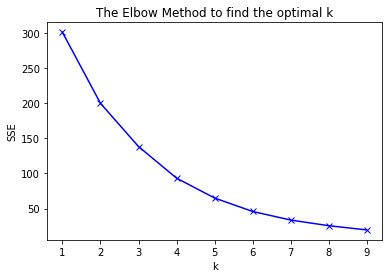

In [37]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state = 123)
    kmeans.fit(y_train)
    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)
print(pd.DataFrame(dict(k=ks, sse=sse)))
plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()






In [38]:
def target_cluster(y_train,X_train):
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(y_train)
    y_train['cluster'] = kmeans.predict(y_train)
    train = X_train.merge(y_train,left_index=True,right_index=True)
    return train






In [39]:
train = target_cluster(y_train,X_train)

In [40]:
train.groupby(['cluster']).mean().sort_values('logerror')

,parcelid,id,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,1bath,2bath,3bath,4bath,5bath,6bath,7bath,1bed,2bed,3bed,4bed,5bed,6bed,7bed,8bed,9bed,logerror
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.177440e+07,1.510351e+06,1.955446,2.809406,6.165842,1643.277228,6037.0,4.339109,3.408463e+07,-1.182897e+08,11841.502475,1.0,1948.806931,149894.799505,438489.722772,288594.923267,0.383663,0.378713,0.165842,0.047030,0.019802,0.004950,0.000000,0.054455,0.339109,0.400990,0.165842,0.027228,0.012376,0.000000,0.000000,0.000000,-0.485299
0,1.191326e+07,1.495758e+06,2.153749,3.000471,6.478372,1626.487746,6037.0,3.626623,3.411553e+07,-1.182469e+08,12112.538385,1.0,1963.804881,157088.536814,390775.331850,233686.795036,0.217428,0.467637,0.269533,0.035767,0.008536,0.000995,0.000105,0.030739,0.255237,0.451718,0.214286,0.042155,0.005027,0.000681,0.000157,0.000000,-0.024329
2,1.186736e+07,1.524090e+06,2.227383,3.056913,6.479463,1734.384161,6037.0,3.694765,3.409838e+07,-1.182575e+08,12280.252215,1.0,1961.885369,163890.003490,417508.672752,253618.669262,0.219060,0.435705,0.266980,0.058255,0.017450,0.002148,0.000403,0.035302,0.253020,0.418389,0.221477,0.059463,0.009799,0.002148,0.000268,0.000134,0.087095


In [41]:
train.cluster.value_counts()

0    19096
2     7450
1      404
Name: cluster, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a250b5b38>,
      dtype=object)

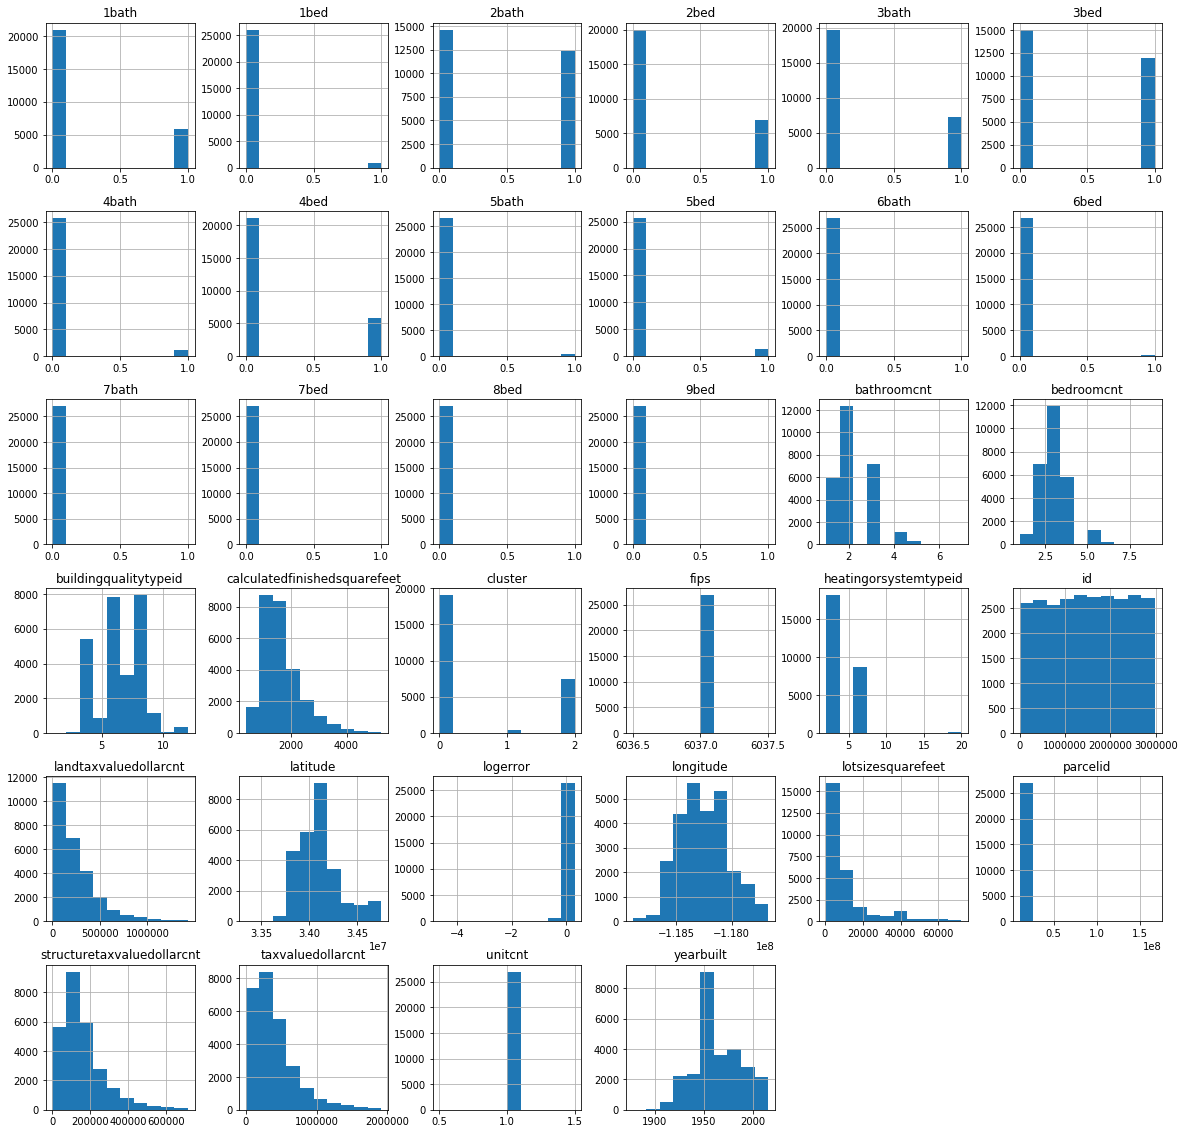

In [42]:
train.hist(figsize=(20, 20), bins=10, log=False)

In [43]:
# for i in train[col].unique().tolist():
#             mean = train[train[col] == i].logerror.mean()
#             std = train[train[col] == i].logerror.std()
#             x = np.linspace(mean-.5,mean+.5,1000)
#             y = norm.pdf(x, loc=mean, scale=std)    # for example
#             plt.plot(x,y, label = i)

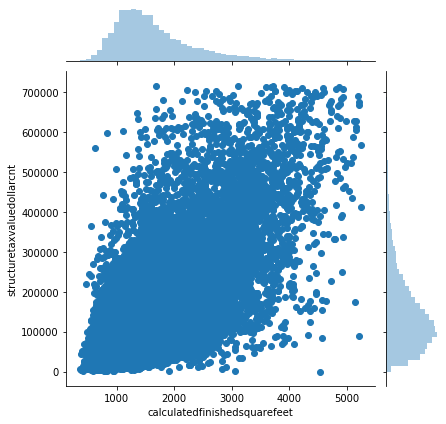

In [44]:
sns.jointplot(data=train, x='calculatedfinishedsquarefeet', y='structuretaxvaluedollarcnt')

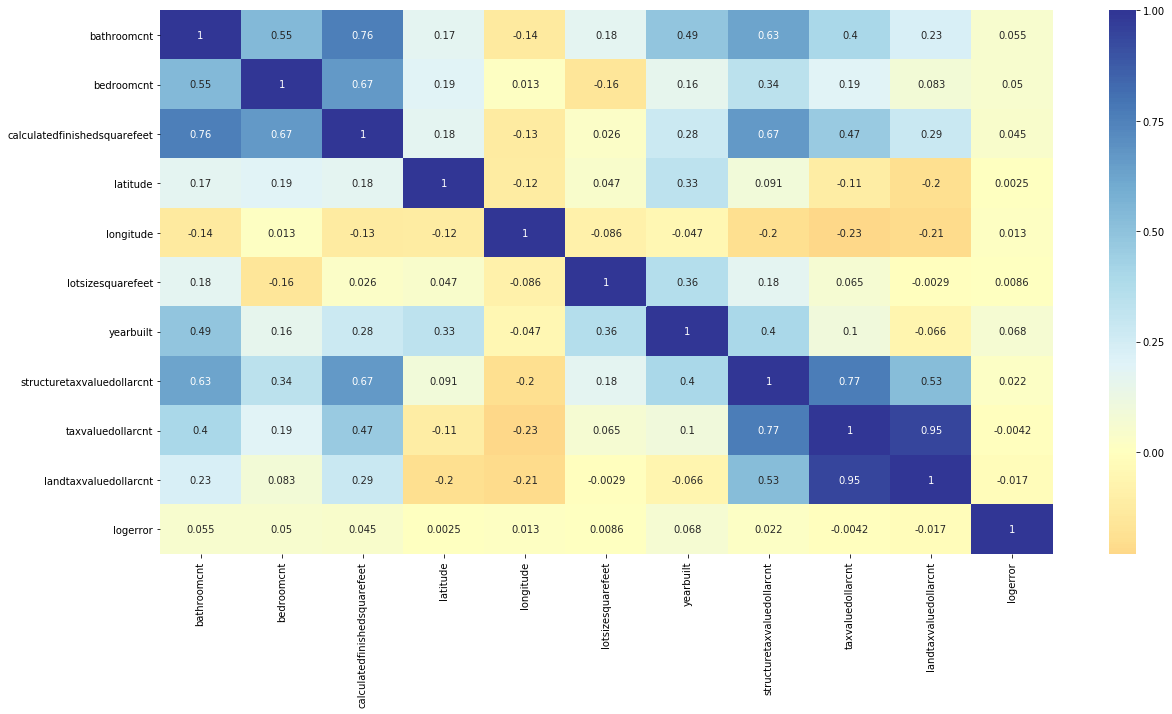

In [45]:
corr1 = train[['bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet','latitude', 'longitude', 'lotsizesquarefeet','yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'logerror']]
plt.figure(figsize=(20,10))
sns.heatmap(corr1.corr(), cmap='RdYlBu', annot=True, center=0)

In [46]:
from scipy import stats


Cluster Independent Variables
You should also perform some clustering based on a number of independent variables. Create and evaluate several clustering models based on subsets of the independent variables. Here are some ideas:

Location, that is, latitude and longitude
Size (finished square feet)
Location and size
Be sure to use these new clusters in exploring your data, and interpret what these clusters tell you.



In [47]:
train.columns

Index(['parcelid', 'id', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'fips', 'heatingorsystemtypeid',
       'latitude', 'longitude', 'lotsizesquarefeet', 'propertyzoningdesc',
       'unitcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'landtaxvaluedollarcnt', '1bath', '2bath', '3bath',
       '4bath', '5bath', '6bath', '7bath', '1bed', '2bed', '3bed', '4bed',
       '5bed', '6bed', '7bed', '8bed', '9bed', 'logerror', 'cluster'],
      dtype='object')

In [48]:
from sklearn.cluster import KMeans

C1 = train[['latitude', 'longitude', 'lotsizesquarefeet']]

kmeans = KMeans(n_clusters=4)
kmeans.fit(C1)

print(kmeans.cluster_centers_)


[[ 3.42003137e+07 -1.18461759e+08  1.41839268e+04]
 [ 3.40682530e+07 -1.17983294e+08  1.15858643e+04]
 [ 3.38953755e+07 -1.18254030e+08  1.04527161e+04]
 [ 3.46294603e+07 -1.18124955e+08  1.14948145e+04]]


In [49]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=C1.columns)
centers
C1Label = pd.Series(kmeans.labels_)
C1Label.value_counts()

0    9621
2    8354
1    6646
3    2329
dtype: int64

[Text(0.5, 0, 'lotsizesquarefeet'),
 Text(0.5, 0, 'latitude'),
 Text(0.5, 0, 'longitude')]

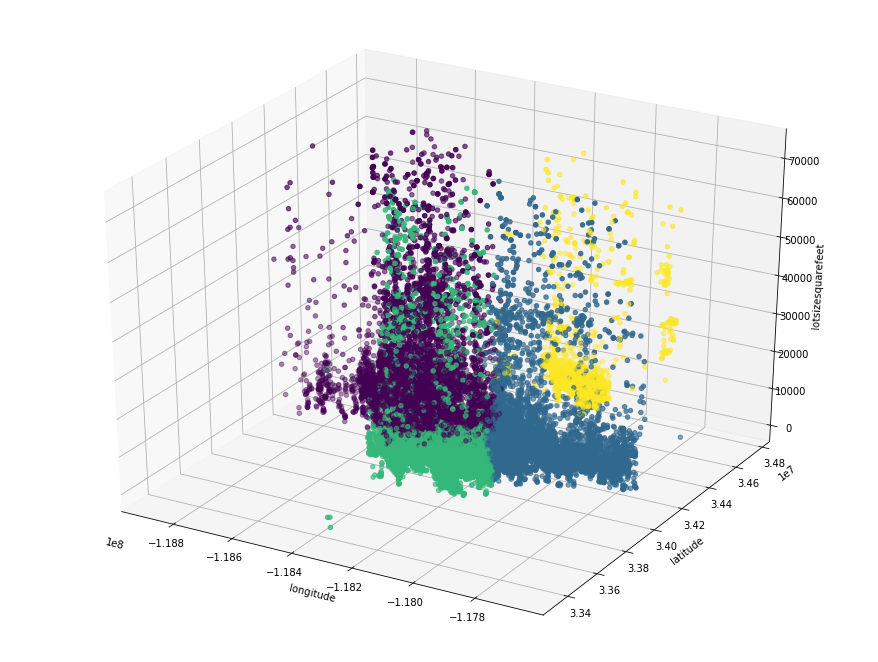

In [50]:
%matplotlib inline

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(C1.longitude, C1.latitude, C1.lotsizesquarefeet, c=kmeans.labels_)
ax.scatter(centers.longitude, centers.latitude, centers.lotsizesquarefeet, c='pink', s=100, alpha=.9)
ax.set(xlabel='longitude', ylabel='latitude', zlabel='lotsizesquarefeet')

In [51]:
C2 = train[['latitude', 'longitude', 'structuretaxvaluedollarcnt']]

kmeans = KMeans(n_clusters=4)
kmeans.fit(C1)
centers2 = pd.DataFrame(kmeans.cluster_centers_, columns=C2.columns)
print(centers2)
C2Label = pd.Series(kmeans.labels_)
C2Label.value_counts()
print(kmeans.cluster_centers_)

       latitude     longitude  structuretaxvaluedollarcnt
0  3.420085e+07 -1.184624e+08                14200.609848
1  3.389611e+07 -1.182547e+08                10454.322038
2  3.406801e+07 -1.179837e+08                11580.513526
3  3.462946e+07 -1.181250e+08                11494.814513
[[ 3.42008485e+07 -1.18462411e+08  1.42006098e+04]
 [ 3.38961126e+07 -1.18254692e+08  1.04543220e+04]
 [ 3.40680052e+07 -1.17983678e+08  1.15805135e+04]
 [ 3.46294603e+07 -1.18124955e+08  1.14948145e+04]]


In [52]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=C2.columns)
centers
C2Label = pd.Series(kmeans.labels_)
C2Label.value_counts()

0    9596
1    8365
2    6660
3    2329
dtype: int64

[Text(0.5, 0, 'structuretaxvaluedollarcnt'),
 Text(0.5, 0, 'latitude'),
 Text(0.5, 0, 'longitude')]

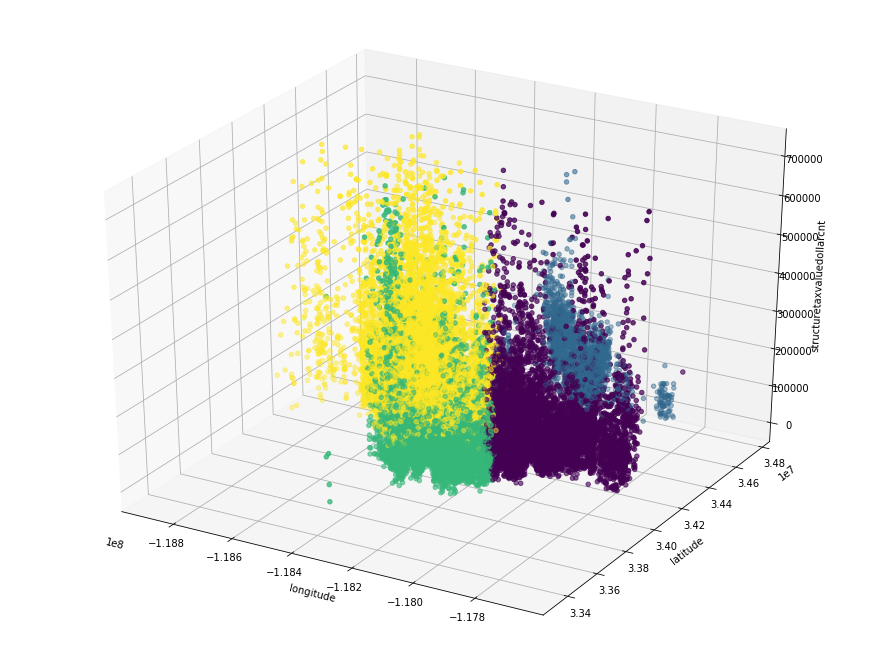

In [61]:
%matplotlib inline

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(C2.longitude, C2.latitude, C2.structuretaxvaluedollarcnt, c=kmeans.labels_)
# ax.scatter(centers.longitude, centers.latitude, centers.structuretaxvaluedollarcnt, c='pink', s=100, alpha=.9)
ax.set(xlabel='longitude', ylabel='latitude', zlabel='structuretaxvaluedollarcnt')

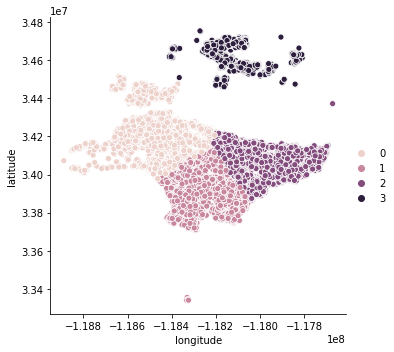

In [54]:
sns.relplot(data=C2, hue=kmeans.labels_, x='longitude', y='latitude')

   k           sse
0  1  2.638030e+15
1  2  1.532504e+15
2  3  9.538659e+14
3  4  5.942574e+14
4  5  4.363497e+14
5  6  3.547522e+14
6  7  2.867998e+14
7  8  2.413186e+14
8  9  2.093192e+14


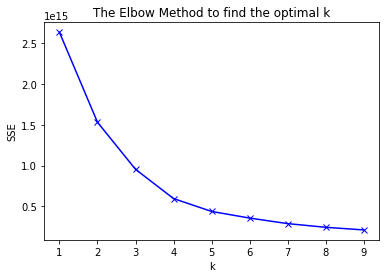

In [55]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state = 123)
    kmeans.fit(train[['longitude', 'latitude', 'logerror']])
    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)
print(pd.DataFrame(dict(k=ks, sse=sse)))
plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()





In [56]:
C3 = train[['latitude', 'longitude', 'logerror']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(C1)
centers3 = pd.DataFrame(kmeans.cluster_centers_, columns=C3.columns)
print(centers3)
C3Label = pd.Series(kmeans.labels_)
C3Label.value_counts()
print(kmeans.cluster_centers_)

       latitude     longitude      logerror
0  3.406785e+07 -1.179850e+08  11546.129306
1  3.462946e+07 -1.181250e+08  11494.814513
2  3.389424e+07 -1.182549e+08  10473.529575
3  3.420020e+07 -1.184618e+08  14184.171512
[[ 3.40678462e+07 -1.17985009e+08  1.15461293e+04]
 [ 3.46294603e+07 -1.18124955e+08  1.14948145e+04]
 [ 3.38942443e+07 -1.18254867e+08  1.04735296e+04]
 [ 3.42002005e+07 -1.18461775e+08  1.41841715e+04]]


In [57]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=C3.columns)
centers
C3Label = pd.Series(kmeans.labels_)
C3Label.value_counts()

3    9624
2    8301
0    6696
1    2329
dtype: int64

[Text(0.5, 0, 'logerror'), Text(0.5, 0, 'longitude'), Text(0.5, 0, 'latitude')]

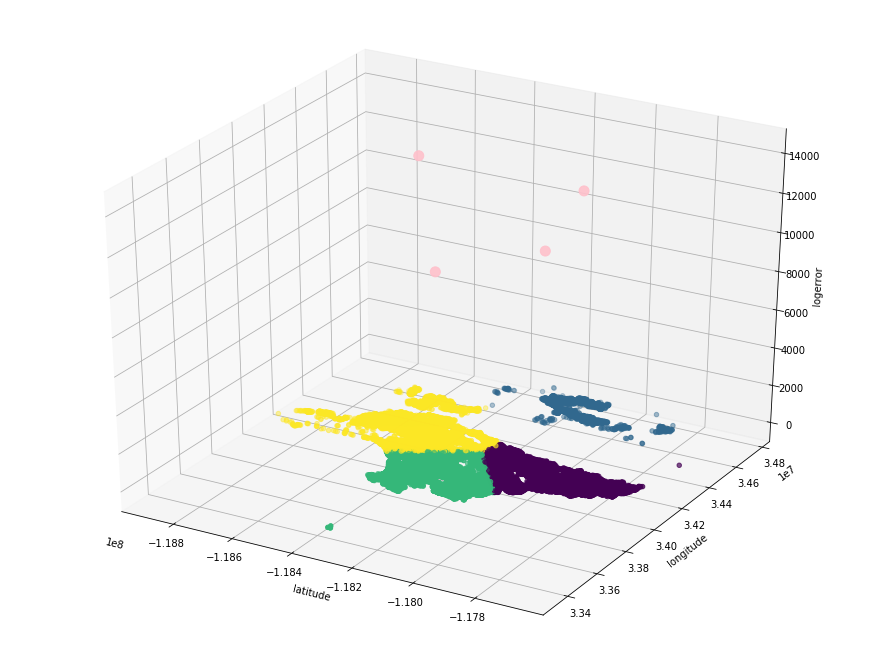

In [58]:
%matplotlib inline

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(C3.longitude, C3.latitude, C3.logerror, c=kmeans.labels_)
ax.scatter(centers.longitude, centers.latitude, centers.logerror, c='pink', s=100, alpha=.9)
ax.set(xlabel='latitude', ylabel='longitude', zlabel='logerror')

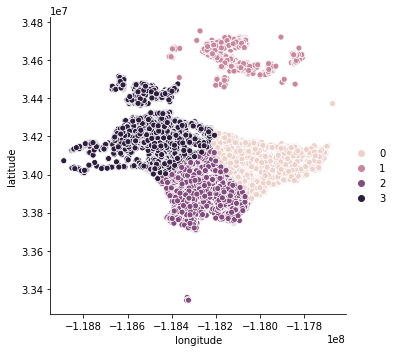

In [59]:
sns.relplot(data=C3, hue=kmeans.labels_, x='longitude', y='latitude')